In [1]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
# %pylab inline
# pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab
from astropy.io import fits

warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
print(astropy.__version__)

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter

# %matplotlib widget
dd = "/Users/kjaehnig/CCA_work/GAT/"

def docs_setup():
    """Set some environment variables and ignore some warnings for the docs"""
    import logging
    import warnings


    # Remove when Theano is updated
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Remove when arviz is updated
    warnings.filterwarnings("ignore", category=UserWarning)

    logger = logging.getLogger("theano.gof.compilelock")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("exoplanet")
    logger.setLevel(logging.DEBUG)

docs_setup()

4.3.1


# LOAD IN ALLVISIT FILE (an absolute unit: ~ 2.75GB)

In [2]:
allvis17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allVisit-dr17-synspec.fits",hdu=1, format='fits')
allstar17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allStar-dr17-synspec-gaiaedr3-xm.fits")
allstar17 = allstar17[(allstar17['bp_rp'] < 10) & (allstar17['phot_g_mean_mag'] < 25)]
calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-min3-calibverr.fits', format='fits', hdu=1)


print(len(allvis17['APOGEE_ID']))
print(allvis17.columns)
hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits', format='fits')
print(len(hq_jk_allstar_tess_edr3))

2659178
<TableColumns names=('APOGEE_ID','TARGET_ID','VISIT_ID','FILE','FIBERID','CARTID','PLATE','MJD','TELESCOPE','SURVEY','FIELD','PROGRAMNAME','ALT_ID','LOCATION_ID','RA','DEC','GLON','GLAT','RELFLUX','MTPFLUX','J','J_ERR','H','H_ERR','K','K_ERR','SRC_H','WASH_M','WASH_M_ERR','WASH_T2','WASH_T2_ERR','DDO51','DDO51_ERR','IRAC_3_6','IRAC_3_6_ERR','IRAC_4_5','IRAC_4_5_ERR','IRAC_5_8','IRAC_5_8_ERR','IRAC_8_0','IRAC_8_0_ERR','WISE_4_5','WISE_4_5_ERR','TARG_4_5','TARG_4_5_ERR','WASH_DDO51_GIANT_FLAG','WASH_DDO51_STAR_FLAG','PMRA','PMDEC','PM_SRC','AK_TARG','AK_TARG_METHOD','AK_WISE','SFD_EBV','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE_TARGET4','TARGFLAGS','SNR','STARFLAG','STARFLAGS','DATEOBS','JD','VLSR','VGSR','CHISQ','SYNTHFILE','MIN_H','MAX_H','MIN_JK','MAX_JK','VREL','VRELERR','VHELIO','BC','RV_TEFF','RV_LOGG','RV_FEH','RV_CARB','RV_ALPHA','XCORR_VREL','XCORR_VRELERR','XCORR_VHELIO','CCFWHM','AUTOFWHM','RV_CHI2','N_COMPONENTS','RV_COMPONENTS','RV_FLAG')>
1741


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_38738/4214507395.py:3: RuntimeWarning: invalid value encountered in log10
  ax.plot(allstar17['bp_rp'], allstar17['phot_bp_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5), marker=',',ls='None',c='gray')
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_38738/4214507395.py:9: RuntimeWarning: invalid value encountered in log10
  - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


Text(0, 0.5, 'G')

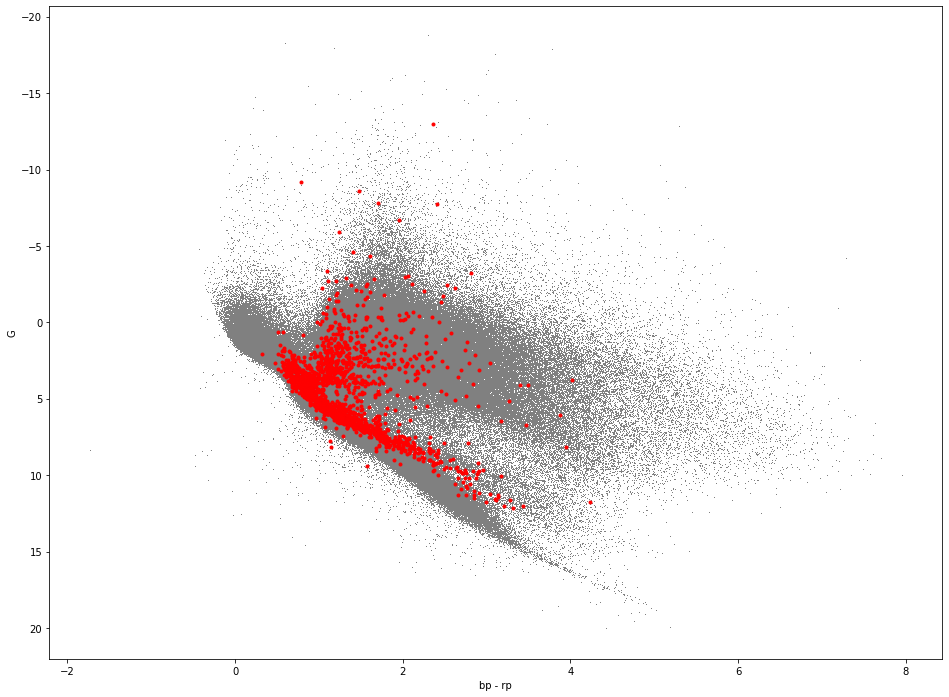

In [3]:
fig,ax = plt.subplots(figsize=(16,12))

ax.plot(allstar17['bp_rp'], allstar17['phot_bp_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5), marker=',',ls='None',c='gray')
y1,y2 = ax.set_ylim()
ax.set_ylim(y2,y1)

ax.plot(hq_jk_allstar_tess_edr3['bp_rp'], 
        hq_jk_allstar_tess_edr3['phot_g_mean_mag'] 
         - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)
           , c='red', marker='.', ls='None') 
ax.set_xlabel("bp - rp")
ax.set_ylabel("G")

114 57


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_38738/2459686942.py:18: RuntimeWarning: invalid value encountered in log10
  ax.plot(allstar17['bp_rp'], allstar17['phot_bp_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5), marker=',',ls='None',c='gray')
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_38738/2459686942.py:24: RuntimeWarning: invalid value encountered in log10
  - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


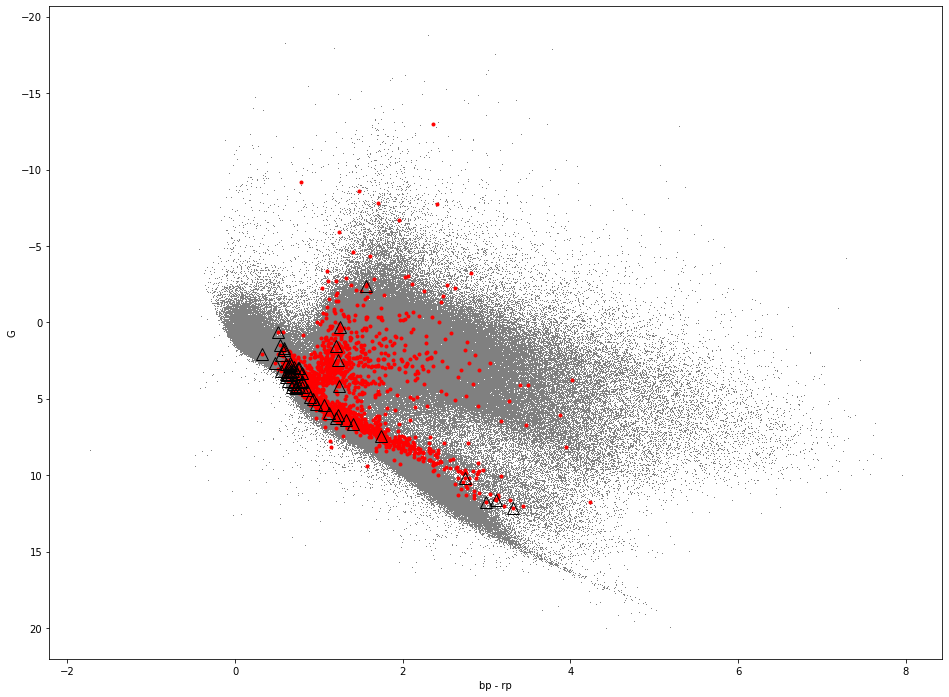

In [4]:
import pickle as pk
import os
dir_ticIDS = os.listdir(dd+'joker_TESS_lightcurve_files')
dir_ticIDS.remove(".DS_Store")

dir_ticIDS = [ii.replace('_lightcurve_data.pickle','') for ii in dir_ticIDS]
dir_ticIDS = [ii.replace('_highres_bls_params.pickle','') for ii in dir_ticIDS]

print(len(dir_ticIDS),len(np.unique(dir_ticIDS)))
dir_ticIDS = np.unique(dir_ticIDS)
right_ids = 0

has_tess_obs = np.in1d(hq_jk_allstar_tess_edr3['ID'],[int(ii.split('_')[1]) for ii in dir_ticIDS])
hq_jk_allstar_tess_edr3_w_tess_obs = hq_jk_allstar_tess_edr3[has_tess_obs]

fig,ax = plt.subplots(figsize=(16,12))

ax.plot(allstar17['bp_rp'], allstar17['phot_bp_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5), marker=',',ls='None',c='gray')
y1,y2 = ax.set_ylim()
ax.set_ylim(y2,y1)

ax.plot(hq_jk_allstar_tess_edr3['bp_rp'], 
        hq_jk_allstar_tess_edr3['phot_g_mean_mag'] 
         - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)
           , c='red', marker='.', ls='None') 
ax.set_xlabel("bp - rp")
ax.set_ylabel("G")

ax.plot(hq_jk_allstar_tess_edr3_w_tess_obs['bp_rp'],
        hq_jk_allstar_tess_edr3_w_tess_obs['phot_g_mean_mag']
        - (5.*np.log10(1000./hq_jk_allstar_tess_edr3_w_tess_obs['parallax']) - 5)
        , c='black', marker='^', ms=12,ls='None',mfc='None')

file = open("/Users/kjaehnig/CCA_work/GAT/tic_ids_of_systems_with_short_cadence_obs.txt",'w')
for ii in dir_ticIDS:
    file.write(ii+'\n')
file.close()

In [5]:
big_tess_lc_dict = {}
print(dir_ticIDS)
for ii in dir_ticIDS:
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{ii}_lightcurve_data.pickle",'rb')
    res = pk.load(file)
    file.close()
    big_tess_lc_dict[ii] = res
file = open("/Users/kjaehnig/CCA_work/GAT/big_lightcurve_dict_shortcadence_tess_obs","wb")
pk.dump(big_tess_lc_dict, file)
file.close()



['TIC_118589804' 'TIC_122304930' 'TIC_126232983' 'TIC_137318531'
 'TIC_137547180' 'TIC_138291351' 'TIC_144424576' 'TIC_144441148'
 'TIC_149539552' 'TIC_158324163' 'TIC_158786520' 'TIC_160072933'
 'TIC_162595188' 'TIC_164458426' 'TIC_164527723' 'TIC_164892194'
 'TIC_165453878' 'TIC_169820068' 'TIC_199497770' 'TIC_20215452'
 'TIC_202371935' 'TIC_219694227' 'TIC_229536143' 'TIC_230064750'
 'TIC_232540911' 'TIC_258108067' 'TIC_261205404' 'TIC_269655424'
 'TIC_271548206' 'TIC_272074664' 'TIC_27530133' 'TIC_28159019'
 'TIC_28188792' 'TIC_28240436' 'TIC_297823453' 'TIC_307857044'
 'TIC_32792896' 'TIC_358154514' 'TIC_365204192' 'TIC_38515566'
 'TIC_39139656' 'TIC_393799536' 'TIC_396928724' 'TIC_399965207'
 'TIC_408018644' 'TIC_423571075' 'TIC_425825018' 'TIC_450325128'
 'TIC_453823509' 'TIC_461630038' 'TIC_461736494' 'TIC_49823764'
 'TIC_77561252' 'TIC_82546444' 'TIC_9429166' 'TIC_97757876' 'TIC_99254945']


(array([ 11.,  30.,  77., 122., 178., 657., 530., 121.,  11.,   4.]),
 array([ 7.678004 ,  8.970924 , 10.2638445, 11.556765 , 12.849685 ,
        14.142605 , 15.435525 , 16.728445 , 18.021366 , 19.314285 ,
        20.607206 ], dtype=float32),
 <BarContainer object of 10 artists>)

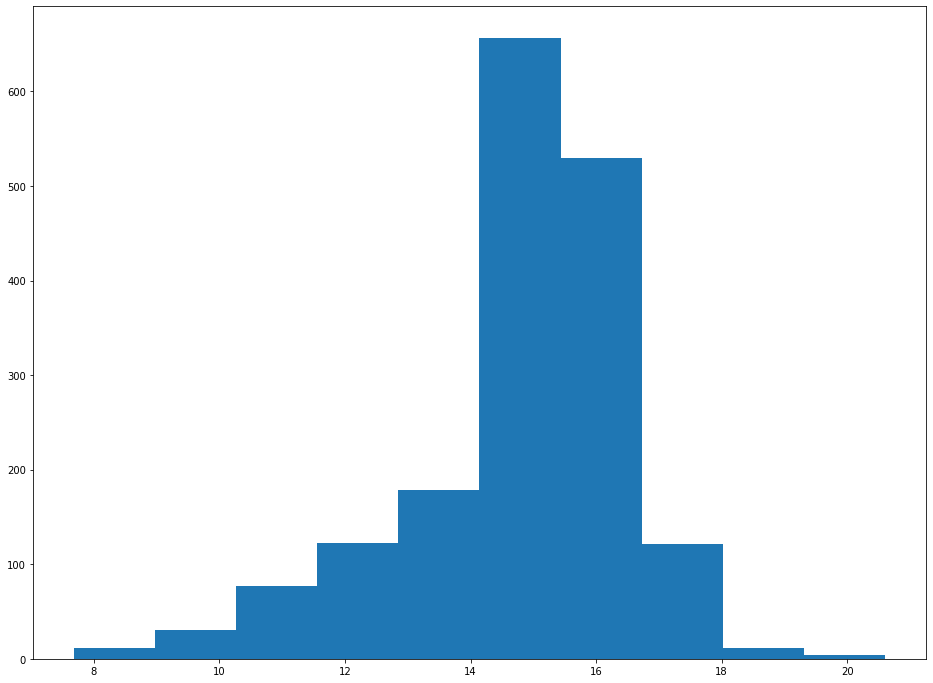

In [6]:
fig,ax = plt.subplots(figsize=(16,12))
ax.hist(hq_jk_allstar_tess_edr3['phot_g_mean_mag'])

#### Load in relevant cross-matches and grab Joker Params for specific TIC ID

In [7]:
target_tic = 'TIC 272074664'
def grab_apogee_rv_data_w_ticID(target_tic='TIC 20215452'):
#     target_tic = 'TIC 20215452'

    #cross-matched star table (has source_id, apogee_id, TIC_id)
    hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3.fits', format='fits')

    #Adrian's calibrated RV_ERRs
    calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-min3-calibverr.fits', format='fits', hdu=1)
#     print(calibverr.info)
    # Grab cross-match IDs
    jk_row = hq_jk_allstar_tess_edr3[hq_jk_allstar_tess_edr3['ID'] == int(target_tic.split(' ')[1])]


    sysapodat = allvis17[allvis17['APOGEE_ID'] == jk_row['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))
#     print(calibverr.info, sysapodat.columns)
    x_rv = sysapodat['JD'] 
    xrv_sorted_ind = np.argsort(x_rv)

    x_rv = x_rv[xrv_sorted_ind]
    y_rv = sysapodat['VHELIO'][xrv_sorted_ind]
    yerr_rv = sysapodat['CALIB_VERR'][xrv_sorted_ind]

    map_t0_bmjd = jk_row['MAP_t0_bmjd']
    t0_bmjd = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')
    t0_bjd = t0_bmjd.tcb.jd

    return ((x_rv, y_rv, yerr_rv),
            jk_row,
            sysapodat
           )


rvdat,jk_row,sysapodat = grab_apogee_rv_data_w_ticID(target_tic=target_tic)
x_rv, y_rv, yerr_rv = rvdat


   MAP_t0_bmjd    
------------------
56934.930298495645       MAP_P       
        d         
------------------
10.476256370544434


'plot multiple tic ids with folded lightcurves and RVs using the BLS period/t0 from the TESS data\n'

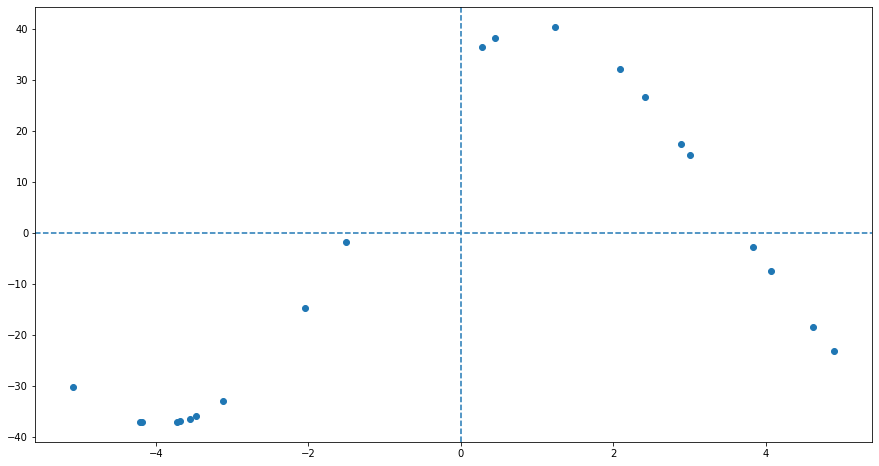

In [8]:
#### DEFINE THE RV,RV_ERRs, and X_RVs for later use in the mcmc... DO NOT REDEFINE ME OR YOU MAKE PYMC3 SAD
# x_rv = sysapodat['JD'] 
# xrv_sorted_ind = np.argsort(x_rv)

# x_rv = x_rv[xrv_sorted_ind]
# y_rv = sysapodat['VHELIO'][xrv_sorted_ind]
# yerr_rv = sysapodat['CALIB_VERR'][xrv_sorted_ind]

map_t0_bmjd = jk_row['MAP_t0_bmjd']
t0_bmjd = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')
t0_bjd = t0_bmjd.tcb.jd

fit,ax = plt.subplots(nrows=1, figsize=(15,8))
print(jk_row['MAP_t0_bmjd'], jk_row['MAP_P'])

plot_per = jk_row['MAP_P'].value
plot_t0 = t0_bjd


ax.scatter(((x_rv - plot_t0 + 0.5*plot_per) % plot_per) - 0.5 * plot_per, y_rv-jk_row['MAP_v0'],)
ax.axhline(0.0,ls='--')
ax.axvline(0.0,ls='--')
# 7.689283720758311 d 1901.7952219793171
# ax.scatter((x_rv-min(x_rv))%jk_row['MAP_P'], y_rv)
# ax.scatter(((x_rv -min(x_rv) + 0.5*jk_row['MAP_P']) % jk_row['MAP_P']) - 0.5 * jk_row['MAP_P'], y_rv)

"""plot multiple tic ids with folded lightcurves and RVs using the BLS period/t0 from the TESS data
"""

In [9]:
target_lk = lk.search_lightcurve('TIC 272074664',
             mission='TESS',
            cadence='short',
            author='SPOC'
             )
print(target_lk)
unpro_lks = target_lk.download_all(quality_bitmask='hardest')
lks = unpro_lks.stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())

lks_2019 = unpro_lks[:2].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
lks_2021 = unpro_lks[2:].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
unpro_lks[0].sector

SearchResult containing 4 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   272074664      0.0
  1 TESS Sector 15 2019   SPOC     120   272074664      0.0
  2 TESS Sector 40 2021   SPOC     120   272074664      0.0
  3 TESS Sector 41 2021   SPOC     120   272074664      0.0


14

In [10]:
def get_multiple_ranges(lk_coll):
    from itertools import groupby
    from operator import itemgetter

    ranges =[]
    inds = []
    data = [ii.sector for ii in lk_coll]
    for k,g in groupby(enumerate(data),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        inds.append([ii in group for ii in data])
        ranges.append((group[0],group[-1]))
        
    return data,ranges, inds
dat,rng,ind = get_multiple_ranges(unpro_lks)

print(dat)
print(len(ind))


[14, 15, 40, 41]
2


In [13]:
def get_texp_from_lightcurve(res):
    with fits.open(res['all_lks'].filename) as hdu:
        hdr = hdu[1].header

    texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
    texp /= 60.0 * 60.0 * 24.0
    print(texp, texp*60*60*24)

    return texp


In [268]:
from matplotlib import cm


def get_multiple_ranges(lk_coll):
    from itertools import groupby
    from operator import itemgetter

    ranges =[]
    inds = []
    data = [ii.sector for ii in lk_coll]
    for k,g in groupby(enumerate(data),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        inds.append([ii in group for ii in data])
        ranges.append((group[0],group[-1]))
        
    return data,ranges,inds


def get_all_transit_params(TIC_ID, jk_row):
    
    res = {'periods':[],
          'durations':[],
          't0s':[],
          'depths':[]}
    
    period_grid = np.exp(np.linspace(np.log(0.5*jk_row['MAP_P']),
                                     np.log(2.*jk_row['MAP_P']),
                                     10000)).squeeze()
    
#     period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),1000))
    dur_grid = np.exp(np.linspace(np.log(0.001),np.log(0.09),50))

    npts = 5000
    pmin = period_grid.min()
    pmax = period_grid.max()
    mindur = dur_grid.min()

    print("Downloading all available TESS data.")
    lk_search = lk.search_lightcurve(TIC_ID,
             mission='TESS',
            cadence='short',
            author='SPOC'
             )
    
    unprocessed_lkcoll = lk_search.download_all(quality_bitmask='hardest')
    all_lks = unprocessed_lkcoll.stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
    
    print("Separating TESS sector data into groups.")
    _, __, grp_ind = get_multiple_ranges(unprocessed_lkcoll)
    
    for ii,ind in enumerate(grp_ind):
        
        print(f"Running BLS on group {ii}, sectors: {unprocessed_lkcoll[ind].sector}")
        lkgrp = unprocessed_lkcoll[ind].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
        
        maxtime = lkgrp.time.max().value
        mintime = lkgrp.time.min().value

        freq_f = int( ((pmin**-1 - pmax**-1) * (maxtime - mintime)**2) / (npts * mindur) ) 
        
        lkgrpBLS = lkgrp.to_periodogram('bls',
                                period=period_grid,
                                frequency_factor = freq_f, duration=dur_grid)
        
        res['periods'].append(lkgrpBLS.period_at_max_power.value)
        res['t0s'].append(lkgrpBLS.transit_time_at_max_power)
        res['durations'].append(lkgrpBLS.duration_at_max_power.value)
        res['depths'].append(lkgrpBLS.depth_at_max_power)
        
    print("Finished.")
    res['unprocessed_lk_coll'] = unprocessed_lkcoll
    res['all_lks'] = all_lks
    res['period_linspace'] = [0.5*jk_row['MAP_P'], 2.*jk_row['MAP_P'], len(period_grid)]
    res['dur_linspace'] = [0.001,0.09, len(dur_grid)]
    res['freq_factor'] = freq_f
    
    return res

def fold(x, period, t0):
    hp = 0.5 * period
    return (x - t0 + hp) % period - hp

def make_folded_lightcurve_from_blsres(TICID):
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_highres_bls_params.pickle",'rb')
    blsres = pk.load(file)
    file.close()

    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_lightcurve_data.pickle","rb")
    res = pk.load(file)
    file.close()
    
        #     print(calibverr.info)
    # Grab cross-match IDs
    sysapodat = allvis17[allvis17['APOGEE_ID'] == res['joker_param']['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))

    
    
    lks = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize())
#     print([len(ii) for ii in blsres['period']])
#     print('sectors: ',res['lk_coll'].sector,'\n'\
#           'bls_per(s): ',blsres['period'],'\n'\
#           'MAP_P: ',res['joker_param']['MAP_P'])

    map_period = res['joker_param']['MAP_P']
    map_t0_bmjd = res['joker_param']['MAP_t0_bmjd']
    map_t0 = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')

    bls_period = blsres['period_at_max_power'].value
    bls_t0 = blsres['t0_at_max_power'].value
        
    rv_time = astropy.time.Time(sysapodat['MJD'], format='mjd', scale='tcb')

    abs_time_vmin = 0.0
    abs_time_vmax = max(lks.time.btjd.max()-lks.time.btjd.min(), rv_time.btjd.max()-rv_time.btjd.min())
#     print(abs_time_vmin, abs_time_vmax)
    
    fig,ax = plt.subplots(figsize=(16,20), nrows=4, ncols=2)
#     ax[-1,-1].remove()
    
    fig.text(0.5,0.885,f'un-folded observations (TESS --- APOGEE) [{TICID}]',
             fontdict={'horizontalalignment':'center','fontweight':'bold','fontsize':14})
    lc_unfolded = ax[0,0].scatter(lks.time.value, lks.flux.value,marker='o', s=0.5,
                              c=lks.time.value - lks.time.min().value, 
                                  vmin=abs_time_vmin, vmax=abs_time_vmax, cmap=cm.inferno)

    rv_unfolded = ax[0,1].plot(rv_time.btjd, 
                               sysapodat['VHELIO'] - res['joker_param']['MAP_v0'],
                               marker='o',ls='None',mec='black')
    
    fig.text(0.5,0.69,'bls folded observations (TESS --- APOGEE)',
             fontdict={'horizontalalignment':'center','fontweight':'bold','fontsize':14})
    
    Nbins = 100  # int(len(lks.time.value) / 1000.)
    bins = np.linspace(-0.5*bls_period, 0.5*bls_period, Nbins)
    x_ = fold(lks.time.value, bls_period, bls_t0)
    y_ = lks.flux.value
    num, _ = np.histogram(x_, bins, weights=y_)
    denom, _ = np.histogram(x_, bins)
    num[denom > 0] /= denom[denom > 0]
    num[denom == 0] = np.nan
#     def running_mean(x, N):
#         cumsum = np.cumsum(np.insert(x, 0, 0)) 
#         return (cumsum[N:] - cumsum[:-N]) / float(N)
    
#     folded_lcx = fold(lks.time.value, bls_period, bls_t0)
#     inds = np.argsort(folded_lcx)
    
#     folded_rmy = running_mean(lks.flux.value[inds],Nbins)
    
#     rmx = np.linspace(folded_lcx.min(), folded_lcx.max(), len(folded_rmy))
#     folded_rmx = fold(rmx, bls_period, bls_t0)
    
    lc_folded_bls = ax[1,0].scatter(fold(lks.time.value, bls_period, bls_t0), 
               lks.flux.value, marker='o',s=0.5,
               c=lks.time.value - lks.time.min().value,
               cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax#fold(lks.time.value, bls_period, bls_t0)
                )
    ax[1,0].plot(0.5 * (bins[1:] + bins[:-1]), num, color='white', lw=6,zorder=10)
    ax[1,0].plot(0.5 * (bins[1:] + bins[:-1]), num, color='cyan', lw=3,zorder=11)
#     ax[1,0].set_ylim(lks.flux.min(), lks.flux.max())
    
    rv_folded_bls = ax[1,1].scatter(fold(sysapodat['MJD'].value, bls_period, blsres['t0_at_max_power'].mjd),
                                    sysapodat['VHELIO']-res['joker_param']['MAP_v0'],
                                    marker='o',c=sysapodat['MJD'].value-min(sysapodat['MJD']),
                                    cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax,
                                    ec='black')
    ax[1,1].axvline(0.0,ls='--')
    ax[1,1].axhline(0.0,ls='--')

    fig.text(0.5,0.49,'MAP folded observations (TESS --- APOGEE)',
             fontdict={'horizontalalignment':'center','fontweight':'bold','fontsize':14})
    lc_folded_map = ax[2,0].scatter(fold(lks.time.value, map_period, map_t0.btjd), 
               lks.flux.value, marker='o',s=0.5,
               c=lks.time.value - lks.time.min().value,
               cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax#fold(lks.time.value, bls_period, bls_t0)
                )
    
    rv_folded_map = ax[2,1].scatter(fold(sysapodat['MJD'].value, map_period, map_t0.mjd),
                                    sysapodat['VHELIO']-res['joker_param']['MAP_v0'],
                                    marker='o',c=sysapodat['MJD'].value-min(sysapodat['MJD']),
                                    cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax,
                                    ec='black')
    fig.colorbar(rv_folded_map, ax=ax[1:3,1],shrink=1.0, pad=0.01, fraction=0.05,label='days')
    ax[2,1].axvline(0.0,ls='--')
    ax[2,1].axhline(0.0,ls='--')
    
    ax[3,0].set_title("GAIA CMD Target Location", fontsize=14, fontweight='bold')
    allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
    unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)
    tess_obs_Gmag = hq_jk_allstar_tess_edr3_w_tess_obs['phot_g_mean_mag'] - (
                        5.*np.log10(1000./hq_jk_allstar_tess_edr3_w_tess_obs['parallax']) - 5)
    target_Gmag = res['joker_param']['phot_g_mean_mag'] - (5.*np.log10(1000./res['joker_param']['parallax']) - 5.)
    
    ax[3,0].plot(allstar17['bp_rp'], allstar_Gmag,
                 marker=',',color='gray', ls='None',label='allstar')
    ax[3,0].plot(hq_jk_allstar_tess_edr3['bp_rp'],unimodal_Gmag,
                 marker='.',color='tab:red',ls='None', label='unimodal')
    ax[3,0].plot(hq_jk_allstar_tess_edr3_w_tess_obs['bp_rp'], tess_obs_Gmag,
                 marker='^',ms=8,color='black',ls='None',mfc='None',label='unimodal w TESS')
    ax[3,0].plot(res['joker_param']['bp_rp'],target_Gmag,
                 marker='^',ms=8,color='tab:blue',lw=2,ls='None',label=TICID)
    ax[3,0].set_ylim(15,-15)
    ax[3,0].set_xlim(-1,7)
    ax[3,0].legend(fontsize=10)
    
    joker_param = hq_jk_allstar_tess_edr3.to_pandas()[hq_jk_allstar_tess_edr3['APOGEE_ID'] == res['joker_param']['APOGEE_ID']]
#     print(joker_param['phot_g_mean_mag'])
    param_str = (f"Gaia G: {joker_param['phot_g_mean_mag'].squeeze()}\nTeff: {int(joker_param['TEFF'].squeeze())}\nLogG: {joker_param['LOGG'].squeeze()}\nM_H: {joker_param['M_H'].squeeze()}\necc: {joker_param['MAP_e'].squeeze()}\nMAP_P: {joker_param['MAP_P'].squeeze()}\nBLS_P: {bls_period}")
    ax[3,1].scatter(0,0,ec='None',fc='None',label=param_str)
    ax[3,1].legend(loc='center',scatterpoints=0, fontsize=18, frameon=False)
    
#     fig.colorbar(lc_folded_)
#     ax.set_xlim(-1,1)

In [278]:
file = open("/Users/kjaehnig/CCA_work/GAT/tic_ids_of_systems_with_short_cadence_obs.txt",'r')
sys_with_tess_obs = file.read().splitlines()
file.close()
print(sys_with_tess_obs)
for ticid in ['TIC_229536143']:
    make_folded_lightcurve_from_blsres(ticid)
    plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_bls_multiplots/{ticid.replace(' ','_').replace('-','_')}_highres_bls_multiplot.png",
                dpi=150, bbox_inches='tight')
    plt.close()

['TIC_118589804', 'TIC_122304930', 'TIC_126232983', 'TIC_137318531', 'TIC_137547180', 'TIC_138291351', 'TIC_144424576', 'TIC_144441148', 'TIC_149539552', 'TIC_158324163', 'TIC_158786520', 'TIC_160072933', 'TIC_162595188', 'TIC_164458426', 'TIC_164527723', 'TIC_164892194', 'TIC_165453878', 'TIC_169820068', 'TIC_199497770', 'TIC_20215452', 'TIC_202371935', 'TIC_219694227', 'TIC_229536143', 'TIC_230064750', 'TIC_232540911', 'TIC_258108067', 'TIC_261205404', 'TIC_269655424', 'TIC_271548206', 'TIC_272074664', 'TIC_27530133', 'TIC_28159019', 'TIC_28188792', 'TIC_28240436', 'TIC_297823453', 'TIC_307857044', 'TIC_32792896', 'TIC_358154514', 'TIC_365204192', 'TIC_38515566', 'TIC_39139656', 'TIC_393799536', 'TIC_396928724', 'TIC_399965207', 'TIC_408018644', 'TIC_423571075', 'TIC_425825018', 'TIC_450325128', 'TIC_453823509', 'TIC_461630038', 'TIC_461736494', 'TIC_49823764', 'TIC_77561252', 'TIC_82546444', 'TIC_9429166', 'TIC_97757876', 'TIC_99254945']


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_38738/22137809.py:193: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_38738/22137809.py:194: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


In [237]:
file = open("/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/TIC_137318531_highres_bls_params.pickle",'rb')
blsres = pk.load(file)
file.close()
print(blsres['period_at_max_power'])

file = open("/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/TIC_137318531_lightcurve_data.pickle","rb")
res = pk.load(file)
file.close()

get_texp_from_lightcurve(res)*24*60

11.606029957851732 d
0.001388888888888889 120.00000000000003


2.0

In [11]:
def get_system_data_for_pymc3_model(TICID):
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_highres_bls_params.pickle",'rb')
    blsres = pk.load(file)
    file.close()

    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_lightcurve_data.pickle","rb")
    res = pk.load(file)
    file.close()
    
        #     print(calibverr.info)
    # Grab cross-match IDs
    sysapodat = allvis17[allvis17['APOGEE_ID'] == res['joker_param']['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))
    
    return (res, blsres, sysapodat)

0.5295868710994996


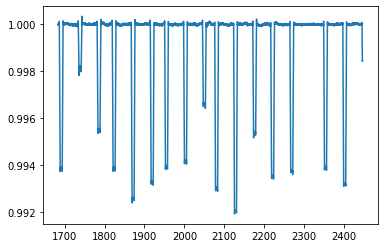

In [281]:
res, blsres, sysapodat = get_system_data_for_pymc3_model('TIC 28159019')
# print(res['joker_param'].to_pandas())
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

rmy = running_mean(res['all_lks'].flux.value,500)
rmx = np.linspace(res['all_lks'].time.value.min(), res['all_lks'].time.value.max(),len(rmy))
plt.figure()
plt.plot(rmx,rmy)
# print(rmy)
print(res['joker_param']['parallax']**-1)

In [214]:


TIC_TARGET = 'TIC 272074664'

res, blsres, sysapodat = get_system_data_for_pymc3_model(TIC_TARGET)

rv_time = astropy.time.Time(sysapodat['MJD'], format='mjd', scale='tcb')

texp = get_texp_from_lightcurve(res)

x_rv = rv_time.btjd
y_rv = sysapodat['VHELIO'] - res['joker_param']['MAP_v0']
yerr_rv = sysapodat['CALIB_VERR']


model_lk_data = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize())
x =    model_lk_data.remove_nans().time.btjd
y =    model_lk_data.remove_nans().flux.value
yerr = model_lk_data.remove_nans().flux_err.value

x_lk_ref = min(x)

x_rv = x_rv - x_lk_ref

x = x - x_lk_ref 

yerr = 1e3*(yerr / np.median(y))
y = (y / np.median(y) - 1)

y *= 1e3


def run_with_sparse_data(x,y,yerr, use_sparse_data=False):
    if use_sparse_data:
        np.random.seed(68594)
        m = np.random.rand(len(x)) < 1.0 / 5
        x = x[m]
        y = y[m]
        yerr = yerr[m]
    return x,y,yerr

x,y,yerr = run_with_sparse_data(x,y,yerr,True)


x = np.ascontiguousarray(x, dtype=np.float64)
y = np.ascontiguousarray(y, dtype=np.float64)
yerr = np.ascontiguousarray(yerr, dtype=np.float64)


x_rv = np.ascontiguousarray(x_rv, dtype=np.float64)
y_rv = np.ascontiguousarray(y_rv, dtype=np.float64)
yerr_rv = np.ascontiguousarray(yerr_rv, dtype=np.float64)

bls_period = blsres['period_at_max_power'].value
print(blsres['t0_at_max_power'].btjd-x_lk_ref)
bls_t0 = blsres['t0_at_max_power'].btjd - x_lk_ref
print('lightcurve N datapoints: ',len(x),len(y),len(yerr), 'transit_epoch: ',bls_t0)


apo_period = jk_row['MAP_P'].value
apo_t0 = map_t0 = astropy.time.Time(res['joker_param']['MAP_t0_bmjd'], format='mjd', scale='tcb').btjd

lit_period = bls_period  #bls_period      ### THESE ARE THE TWO VARIABLES USED
lit_t0 = bls_t0   #bls_t0             ### IN THE PYMC3 MODEL BELOW


transit_mask = model_lk_data.create_transit_mask(
    period=blsres['period_at_max_power'].value,
    duration=5.*blsres['duration_at_max_power'].value,
    transit_time=blsres['t0_at_max_power']
)

no_transit_lks = model_lk_data[~transit_mask]
y_masked = 1000 * (no_transit_lks.flux.value / np.median(no_transit_lks.flux.value) - 1)
lk_sigma = np.std(y_masked)
print(lk_sigma)

Ntrans = np.floor((x.max() - lit_t0) / lit_period)
print(Ntrans)
lit_tn = lit_t0  + Ntrans * lit_period


0.001388888888888889 120.00000000000003
5.236000000000104
lightcurve N datapoints:  14419 14419 14419 transit_epoch:  5.236000000000104
5.0483117
72.0


(-5.761459427998234, 5.761490639255995)

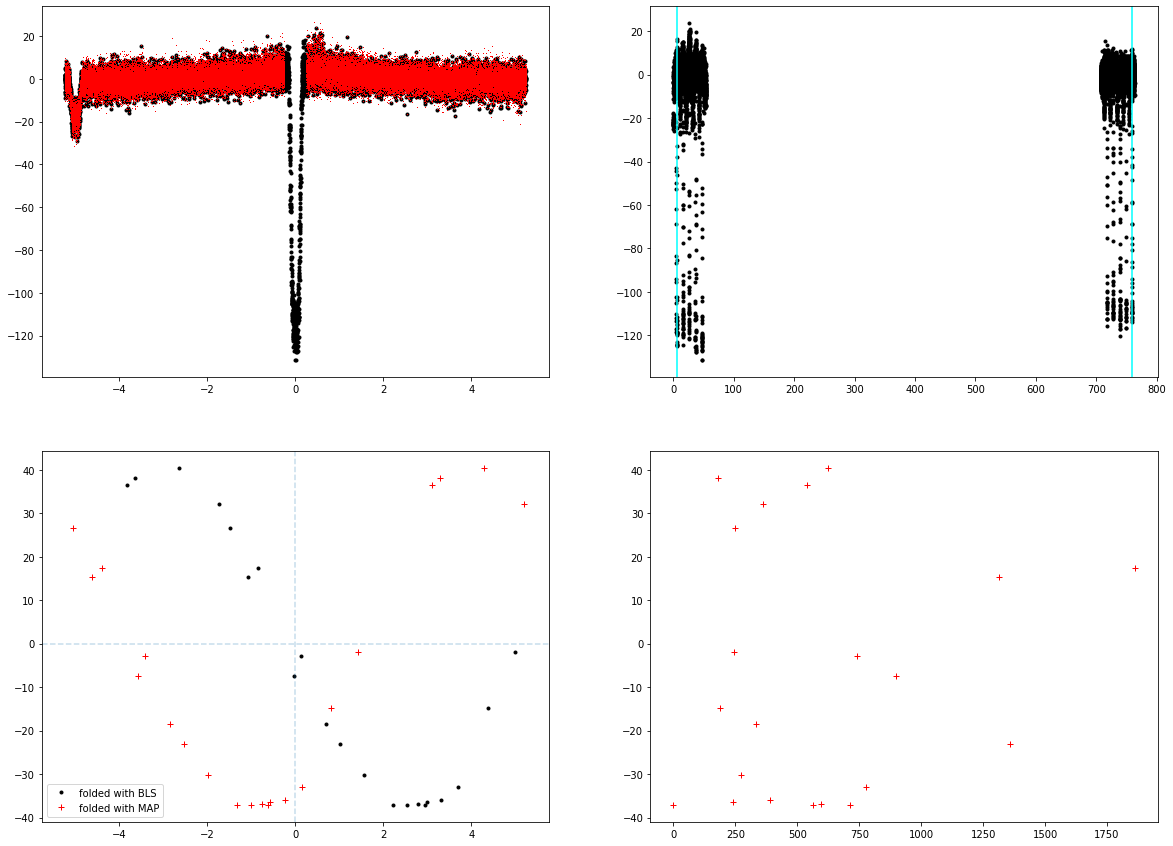

In [215]:
fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
# print(axes)
axes[0][0].plot(
    fold(x, lit_period, lit_t0), y, ".k"
)

axes[0][0].plot(
    fold(no_transit_lks.time.value-x_lk_ref, lit_period, lit_t0),
    y_masked, ",r"
)

axes[1][0].plot(
    fold(x_rv, bls_period, bls_t0), y_rv, ".k",
    label='folded with BLS'
)
axes[1][0].plot(
    fold(x_rv, apo_period, apo_t0), y_rv, "+r",
    label='folded with MAP'
)

axes[1][0].legend()
axes[0][1].plot(x, y, ".k")
axes[0][1].axvline(lit_t0, c='cyan')
axes[0][1].axvline(lit_tn,c='cyan')
axes[1][1].plot(x_rv-min(x_rv), y_rv, "+r")

# x_rv = x_rv - lit_t0

np.all(x_rv[1:] - x_rv[:-1] > 0.0)
axes[1][0].axvline(0.0,ls='--',alpha=0.25)
axes[1][0].axhline(0.0,ls='--',alpha=0.25)


x1m, x1p = axes[0][0].set_xlim()
axes[1][0].set_xlim(x1m,x1p)

In [279]:
Msecondary = xo.estimate_minimum_mass(periods=bls_period, x=x_rv, y=y_rv*u.km/u.s, yerr=yerr_rv*u.km/u.s, t0s=bls_t0, m_star=0.77*u.M_sun).to(u.M_sun).value
print(Msecondary)

[0.33382832]


In [232]:
def plot_MAP_rv_curve_diagnostic_plot(model, soln, extras, mask, title):
    if mask is None:
        mask = np.ones(len(extras['x']), dtype=bool)
    
    if 'period' in soln.keys():
        period = soln['period']
    elif 'log_period' in soln.keys():
        period = np.exp(soln['log_period'])
    else:
        period = np.exp(soln['log_period_interval__'])
        
    x = extras['x']
    y = extras['y']
    t_lc_pred = np.linspace(x.min(), x.max(), 3000) 
    
    t0 = soln['t0']
    mean = soln['mean_rv']
    x_phase = np.linspace(-0.5*period, 0.5*period, 1000)
    
    x_rv = extras['x_rv']
    y_rv = extras['y_rv']
    
    with model:
        gp_pred = (
            pmx.eval_in_model(extras["gp_lc_pred"], soln) + soln["mean_lc"]
        )
        lc = (
            pmx.eval_in_model(extras["model_lc"](x), soln)
            - soln["mean_lc"]
        )

        y_rv_mod = pmx.eval_in_model(extras['model_rv'](x_phase + t0), soln) - soln['mean_rv']
    
    # fig, axes = plt.subplots(nrows=3)
    gsfig = GridSpec(nrows=140,ncols=100)
    fig = plt.figure(figsize=(12,8), constrained_layout=False)

    fig, ax4 = plt.subplots(figsize=(12,18))

    ax1 = fig.add_subplot(gsfig[:30,:])
    ax2 = fig.add_subplot(gsfig[30:60,:])
    ax3 = fig.add_subplot(gsfig[70:100,:])
    ax4 = fig.add_subplot(gsfig[110:,:])
    
    ax1.tick_params(labelbottom=False,direction='in')
    ax2.tick_params(bottom=True,direction='in')

    ax1.plot(x, y, "k.", alpha=0.2)
    ax1.plot(x, gp_pred, color="C1", lw=1)
    ax1.plot(x,lc,'C2')

    ax1.set_xlim(x.max()-10,x.max())# x.max())


#     ax2.plot(x, y - gp_pred, "k.", alpha=0.2)
#     ax2.plot(x, lc, color="C2", lw=1)
    ax2.plot(x, y-lc, color='C2', lw=2)
    ax2.set_xlim(x.max()-10,x.max())# x.max())

    ax1.set_ylabel("raw flux [ppt]")
    ax2.set_ylabel("de-trended flux [ppt]")
    ax2.set_xlabel("time [TBJD]")



    x_fold = (
        (extras["x"] - t0) % period / period
    )
    inds = np.argsort(x_fold)

    ax3.plot(x_fold[inds], extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
    ax3.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
#     ax2.plot(
#         x_fold[mask][inds],
#         extras["y"][mask][inds] - gp_pred[mask][inds],
#         "k.",
#         alpha=0.2,
#         label="data!",
#     )
#     ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

    yval = extras["y"][inds] - gp_pred
    bins = np.linspace(0, 1, 75)
    num, _ = np.histogram(x_fold[inds], bins, weights=yval)
    denom, _ = np.histogram(x_fold[inds], bins)
#     ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

    args = dict(lw=1)

    x_fold = (x - t0) % period / period
    inds = np.argsort(x_fold)
    ax3.plot(x_fold[inds], lc[inds], "C2", **args)
    ax3.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

    ax3.set_xlim(-1, 1)
    ax3.set_ylabel("de-trended flux [ppt]")
    ax3.set_xlabel("phase")
    
    x_rv_fold = (x_rv - t0 + 0.5*period) % period - 0.5*period
    ax4.plot(x_phase, y_rv_mod, "C0")
    ax4.plot(fold(x_rv,period,t0), y_rv-mean, ".", label='RV obs')
    ax4.set_title(title)
    plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_{title.replace(' ','_')}_plot.png",
                bbox_inches='tight', dpi=150)
    plt.close()

In [233]:
print(y_rv,yerr_rv)

[-37.09734728 -18.39070288  32.20986141 -32.98741235  17.51284717
  38.23120127 -14.82917391 -30.26120224  36.50884283  40.42627534
  -7.46820163 -36.43921323  -1.80876127  26.70619114 -37.0798261
 -36.96012601 -37.10612632 -23.1530003  -35.96711472  -2.81403937
  15.32484267] [0.08068925 0.08169927 0.07329115 0.07293097 0.07102282 0.06930987
 0.07639772 0.08284066 0.0776441  0.07386115 0.08040746 0.07595099
 0.07782801 0.08561637 0.07706631 0.07750777 0.09133556 0.08061271
 0.07388609 0.08284431 0.07035763]


In [238]:
t = np.linspace(x_rv.min(), x_rv.max(), 5000)
tlc = np.linspace(x.min(), x.max(), 5000)

rvK = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv*u.km/u.s, yerr_rv*u.km/u.s, t0s=bls_t0)[0]
print(rvK)

mask = x < 400
def build_model(mask=None, start=None, plot_MAP_diagnostic_rv_curves=False):
    if mask is None:
        mask = np.ones(len(x), dtype='bool')
    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=10.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)

        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        log_M1 = pm.Normal("log_M1", mu=0.0, sigma=10.0)
#         log_R1 = pm.Uniform('log_R1', lower=np.log(1e-5), upper=np.log(1000))
        log_R1 = pm.Normal("log_R1", mu=0.0, sigma=10.0)
        M1 = pm.Deterministic("M1", tt.exp(log_M1))
        R1 = pm.Deterministic("R1", tt.exp(log_R1))

        # Secondary ratios
        log_k = pm.Normal("log_k", mu=0.0, sigma=5.0)  # radius ratio
        
#         logK = pm.Normal("logK", mu=np.log(rvK), sigma=5.0, testval=np.log(rvK)) 
        
        log_q = pm.Normal("log_q", mu=0.0, sigma=5.0, testval=np.log(0.25))  # mass ratio
        log_s = pm.Normal("log_s", mu=0.0, sigma=10.0, testval = np.log(0.5))  # surface brightness ratio
        k = pm.Deterministic("k", tt.exp(log_k))
        pm.Deterministic("q", tt.exp(log_q))
        pm.Deterministic("s", tt.exp(log_s))

        # Prior on flux ratio
#         pm.Normal(
#             "flux_prior",
#             mu=0.5,
#             sigma=0.25,
#             observed=tt.exp(2 * log_k + log_s),
#         )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=0.5)
#         log_period = pm.Uniform(
#                 "log_period",
#                 lower=np.log(0.1),
#                 upper=np.log(3*lit_period),
#                 testval=np.log(lit_period)
#         )
            
#         log_period = pm.Normal("log_period", mu=np.log(lit_period), sigma=5.0)
#         period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)
        tn = pm.Normal("tn", mu=lit_tn, sigma=1.0)
        period = pm.Deterministic("period", (tn - t0) / Ntrans)
        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.04, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", tt.exp(log_k + log_R1))
        M2 = pm.Deterministic("M2", tt.exp(log_q + log_M1))
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
        
        
        
        
        # Noise model for the light curve
        
        
        
        sigma_lc = pm.InverseGamma(
            "sigma_lc",
            testval= np.mean(yerr),
            **pmx.estimate_inverse_gamma_parameters(0.1,5.0)
        )
        
        
        sigma_gp = pm.InverseGamma(
            "sigma_gp",
            testval= lk_sigma,
            **pmx.estimate_inverse_gamma_parameters(0.1,10.0),
        )
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval= 2.0 * bls_period,
            **pmx.estimate_inverse_gamma_parameters(0.1,10.0)
        )
#         sigma_lc = np.mean(yerr)
#         sigma_gp = lk_sigma
#         rho_gp = 0.25*lit_period
        print(sigma_lc, sigma_gp, rho_gp)
        kernel_lc = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3.)

#         # Noise model for the radial velocities
#         sigma_rv = pm.InverseGamma(
#             "sigma_rv",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         sigma_rv_gp = pm.InverseGamma(
#             "sigma_rv_gp",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         rho_rv_gp = pm.InverseGamma(
#             "rho_rv_gp",
#             testval=2.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 25.0)
#         )
#         kernel_rv = terms.SHOTerm(sigma=sigma_rv_gp, w0=rho_rv_gp, Q=1.0 / 3.)

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, tt.exp(log_s))

        def model_lc(t):
            return (
                mean_lc
                + 1e3
                * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:,0]
            )

        pm.Deterministic(
            "lc_pred",
            model_lc(x)
        )
        
        # Condition the light curve model on the data
        gp_lc = GaussianProcess(kernel_lc, t=x[mask], yerr=sigma_lc)
        gp_lc.marginal("obs_lc", observed=y[mask] - model_lc(x[mask]))


#         # Set up the radial velocity model


        log_sigma_rv = pm.Normal(
            "log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=10.0
        )

        def model_rv(t):
            return 1e-3*orbit.get_radial_velocity(t) + mean_rv
            
        rv_model = model_rv(x_rv)
        
        err = tt.sqrt(yerr_rv**2. + tt.exp(2*log_sigma_rv))
        
#         pm.Normal("obs",mu=rv_model, sd=err, observed=y_rv)

        # Optimize the logp
        if start is None:
            start = model.test_point

            
        extras = dict(
            x=x[mask],
            y=y[mask],
            x_rv = x_rv,
            y_rv = y_rv,
            model_lc=model_lc,
            model_rv=model_rv,
            gp_lc_pred=gp_lc.predict(y[mask] - model_lc(x[mask])),
        )
        
        
        # First the RV parameters
        print(model.check_test_point())
        opti_logp = []
        map_soln, info_ = pmx.optimize(start, log_k, return_info=True)
        map_soln, info_ = pmx.optimize(map_soln, [b], return_info=True)
        map_soln, info_ = pmx.optimize(map_soln, [log_s], return_info=True)
        map_soln, info_ = pmx.optimize(start, log_M1, return_info=True)
        map_soln, info_ = pmx.optimize(map_soln, [tn, t0], return_info=True)        
        map_soln, info_ = pmx.optimize(map_soln, [log_k, b, log_s, tn, t0, u1, u2, log_M1], return_info=True)
        map_soln, info_ = pmx.optimize(map_soln, [u1,u2], return_info=True)
#         map_soln, info_ = pmx.optimize(map_soln, [log_q], return_info=True)



#         map_soln, info_ = pmx.optimize(map_soln, [mean_lc, rho_gp, sigma_gp, sigma_lc], return_info=True)
#         map_soln, info_ = pmx.optimize(map_soln, [log_sigma_rv], return_info=True)
#         map_soln, info_ = pmx.optimize(map_soln, [ecs], return_info=True)









        opti_logp.append(-info_['fun'])
        if plot_MAP_diagnostic_rv_curves:
            plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title='end_times')
            assert False
        #         map_vars = [mean_lc, mean_rv, b, log_R1, 
#                     log_k, log_s, ecs, u1, u2, t0, 
#                     log_period, sigma_lc, sigma_rv, 
#                     sigma_gp, sigma_rv_gp, rho_gp, rho_rv_gp]
        
        map_vars = [ [tn,t0], ecs, b,
                    [ecs, b],
                    log_q, log_s, log_k,
                     log_M1, log_R1,
                    log_sigma_rv, mean_rv,
                    [mean_rv, log_q, ecs],
                    [mean_lc, rho_gp, sigma_gp, sigma_lc],
                    [mean_lc,u1,u2],
                    [t0,tn]]

#         map_vars = [[log_period, t0]]#,log_q, log_s, [ecs, b, log_k], [mean_lc,u1,u2], log_M1, log_R1,
#         map_soln = pmx.optimize(
#             map_soln, [mean_rv, sigma_rv1, sigma_rv2, sigma_rv_gp, rho_rv_gp]
#         )


    
        map_vars_dict = {
            't0_tn' : [tn,t0],
#             'ecs' : ecs,
            'b' : b,
            'log_k' : log_k,
#             'ecs_b' : [ecs, b],
            'log_q' : log_q,
            'log_s' : log_s,
            'log_M1': log_M1,
            'log_R1': log_R1,
            'log_sigma_rv': log_sigma_rv,
            'mean_rv': mean_rv,
#             'logq_ecs': [log_q, mean_rv],
            'u1_u2': [u1,u2],
            'lc_gps' : [mean_lc, rho_gp, sigma_gp, sigma_lc],
            'mean_lc_u1u2': [mean_lc, u1,u2],
            't0_tn' : [tn,t0]

        }
        map_vars_names = np.array(list(map_vars_dict.keys()))
        print(map_vars_names)
        
        failed_mvar_list = []
        for ii,mvar_grp in enumerate(map_vars_names):
            map_soln, info_ = pmx.optimize(
                                    map_soln, 
                                    vars = map_vars_dict[mvar_grp], 
                                    return_info=True
            )
            if np.isfinite(info_['fun']):
                opti_logp.append(-info_['fun'])
                if plot_MAP_diagnostic_rv_curves:
                    plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after {mvar_grp} opt')
            else:
                #mar_vars_names = np.insert(map_vars_names, ii+2, mvar_grp)
                failed_mvar_list.append(mvar_grp)
                
            if len(failed_mvar_list) > 0:
                for failed_mvar in failed_mvar_list:
                    map_soln, info_ = pmx.optimize(
                                        map_soln, 
                                        vars = map_vars_dict[failed_mvar], 
                                        return_info=True
                    )
                    if np.isfinite(info_['fun']):
                        opti_logp.append(-info_['fun'])
                        if plot_MAP_diagnostic_rv_curves:
                            plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                              title=f'RVs after {failed_mvar} opt')
                        failed_mvar_list.remove(failed_mvar)
                    else:
                        continue


    return model, map_soln, extras, start, opti_logp



# working_params = []
# final_model_logp = []
# for ii in range(100):
#     try:
#         sigma_lc_gaminv_alph = np.round(np.random.uniform(low=0.1,high=1.0),1)
#         sigma_lc_gaminv_beta = np.round(np.random.uniform(low=1.0,high=25.0),0)
        
#         sigma_gp_gaminv_alph = np.round(np.random.uniform(low=0.1,high=1.0),1)
#         sigma_gp_gaminv_beta = np.round(np.random.uniform(low=1.0,high=25.),0)
        
#         rho_gp_gaminv_alph = np.round(np.random.uniform(low=0.1,high=1.0),1)
#         rho_gp_gaminv_beta = np.round(np.random.uniform(low=1.0,high=10.0),0)
        
#         model, map_soln, extras, start, opti_logp = build_model(lc_gp_params=[
#                                                                     sigma_lc_gaminv_alph,
#                                                                     sigma_lc_gaminv_beta,
#                                                                     sigma_gp_gaminv_alph,
#                                                                     sigma_gp_gaminv_beta,
#                                                                     rho_gp_gaminv_alph,
#                                                                     rho_gp_gaminv_beta
#         ])
#         working_params.append([sigma_lc_gaminv_alph,
#                                 sigma_lc_gaminv_beta,
#                                 sigma_gp_gaminv_alph,
#                                 sigma_gp_gaminv_beta,
#                                 rho_gp_gaminv_alph,
#                                 rho_gp_gaminv_beta])
#         final_model_logp.append(opti_logp[-1])
#     except:
#         pass

model, map_soln, extras, start, opti_logp = build_model(mask=mask,plot_MAP_diagnostic_rv_curves=True)

print("#" * 50)
print("#"*19 +"  FINISHED  " + "#"*19)
print("#"*50)

38665.54201668238
sigma_lc ~ InverseGamma sigma_gp ~ InverseGamma rho_gp ~ InverseGamma
mean_lc                        -3.22
mean_rv                        -4.83
u1_quadlimbdark__              -2.77
u2_quadlimbdark__              -2.77
log_M1                         -3.22
log_R1                         -3.22
log_k                          -2.53
log_q                          -2.57
log_s                          -3.22
b_impact__                     -1.67
t0                             -0.92
tn                             -0.92
ecs_unitdisk+interval__        -1.39
sigma_lc_log__                 -3.53
sigma_gp_log__                 -3.26
rho_gp_log__                   -5.30
log_sigma_rv                   -3.22
obs_lc                    -371605.47
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [log_k]


message: Desired error not necessarily achieved due to precision loss.
logp: -371654.04720009555 -> -37693.338509736546
optimizing logp for variables: [b, log_k]


message: Optimization terminated successfully.
logp: -37693.338509736546 -> -35557.03079075608
optimizing logp for variables: [log_s]


message: Optimization terminated successfully.
logp: -35557.03079075608 -> -32643.44435668357
optimizing logp for variables: [log_M1]


message: Optimization terminated successfully.
logp: -371654.04720009555 -> -78898.35457105468
optimizing logp for variables: [t0, tn]


message: Desired error not necessarily achieved due to precision loss.
logp: -78898.35457105468 -> -78898.34791346938
optimizing logp for variables: [log_M1, u2, u1, t0, tn, log_s, b, log_k]


message: Desired error not necessarily achieved due to precision loss.
logp: -78898.34791346938 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [u2, u1]


message: Optimization terminated successfully.
logp: -78898.34791346938 -> -78898.34791346938


AssertionError: 

<Figure size 864x576 with 0 Axes>

In [ ]:
print(np.exp(map_soln['log_period']),lit_period,(np.exp(map_soln['log_period'])-lit_period) )
print(jk_row['MAP_P'])

fig,ax = plt.subplots()
ax.plot(range(len(opti_logp)), opti_logp)

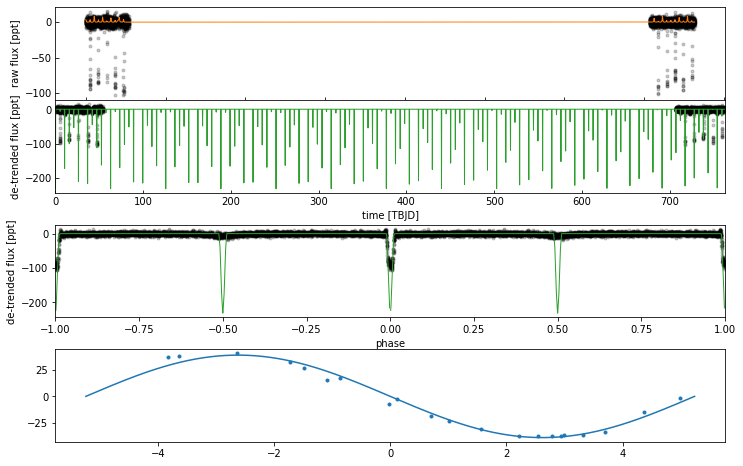

In [63]:
def plot_diagnostic_plots(soln, extras, mask):
    if mask is None:
        mask = np.ones(len(extras['x']), dtype=bool)
    
    if 'period' in soln.keys():
        period = soln['period']
    elif 'log_period' in soln.keys():
        period = np.exp(soln['log_period'])
    else:
        period = np.exp(soln['log_period_interval__'])
        
    x = extras['x'][mask]
    y = extras['y'][mask]
    t_lc_pred = np.linspace(x.min(), x.max(), 3000)
    
    t0 = soln['t0']
    mean = soln['mean_rv']
    x_phase = np.linspace(-0.5*period, 0.5*period, 1000)
    
    x_rv = extras['x_rv']
    y_rv = extras['y_rv']
    
    with model:
        gp_pred = (
            pmx.eval_in_model(extras["gp_lc_pred"], soln) + soln["mean_lc"]
        )
        lc = (
            pmx.eval_in_model(extras["model_lc"](t_lc_pred), soln)
            - soln["mean_lc"]
        )

        y_rv_mod = pmx.eval_in_model(extras['model_rv'](x_phase + t0), soln) - soln['mean_rv']
    
    # fig, axes = plt.subplots(nrows=3)
    gsfig = GridSpec(nrows=140,ncols=100)
    fig = plt.figure(figsize=(12,8), constrained_layout=False)



    ax1 = fig.add_subplot(gsfig[:30,:])
    ax2 = fig.add_subplot(gsfig[30:60,:])
    ax3 = fig.add_subplot(gsfig[70:100,:])
    ax4 = fig.add_subplot(gsfig[110:,:])
    
    ax1.tick_params(labelbottom=False,direction='in')
    ax2.tick_params(bottom=True,direction='in')

    ax1.plot(x, y, "k.", alpha=0.2)
    ax1.plot(x, gp_pred[mask], color="C1", lw=1)
    ax2.set_xlim(x.min(), y.max())

    ax2.plot(x, y - gp_pred, "k.", alpha=0.2)
    ax2.plot(t_lc_pred, lc, color="C2", lw=1)
    ax2.set_xlim(x.min(), x.max())

    ax1.set_ylabel("raw flux [ppt]")
    ax2.set_ylabel("de-trended flux [ppt]")
    ax2.set_xlabel("time [TBJD]")



    x_fold = (
        (extras["x"][mask] - t0) % period / period
    )
    inds = np.argsort(x_fold)

    ax3.plot(x_fold[mask][inds], extras["y"][mask][inds] - gp_pred[mask][inds], "k.", alpha=0.2)
    ax3.plot(x_fold[mask][inds] - 1, extras["y"][mask][inds] - gp_pred[mask][inds], "k.", alpha=0.2)
#     ax2.plot(
#         x_fold[mask][inds],
#         extras["y"][mask][inds] - gp_pred[mask][inds],
#         "k.",
#         alpha=0.2,
#         label="data!",
#     )
#     ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

    yval = extras["y"][inds] - gp_pred
    bins = np.linspace(0, 1, 75)
    num, _ = np.histogram(x_fold[inds], bins, weights=yval)
    denom, _ = np.histogram(x_fold[inds], bins)
#     ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

    args = dict(lw=1)

    x_fold = (t_lc_pred - t0) % period / period
    inds = np.argsort(x_fold)
    ax3.plot(x_fold[inds], lc[inds], "C2", **args)
    ax3.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

    ax3.set_xlim(-1, 1)
    ax3.set_ylabel("de-trended flux [ppt]")
    ax3.set_xlabel("phase")
    
    x_rv_fold = (x_rv - t0 + 0.5*period) % period - 0.5*period
    ax4.plot(x_phase, y_rv_mod, "C0")
    ax4.plot(fold(x_rv,period,t0), y_rv-mean, ".", label='RV obs')
    
plot_diagnostic_plots(start, extras, mask=None)

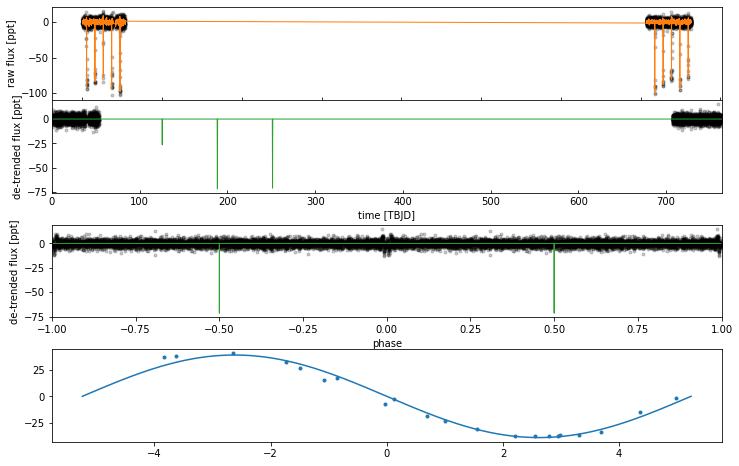

In [64]:
plot_diagnostic_plots(map_soln, extras, mask=None)

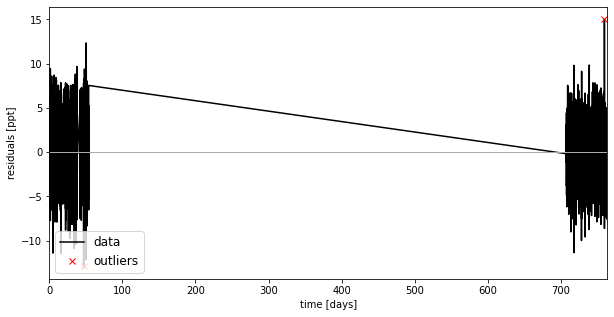

In [65]:
with model:
    mod = pmx.eval_in_model(
        extras['model_lc'](extras['x']) + extras['gp_lc_pred'],
        map_soln,
    )
    
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 7 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

optimizing logp for variables: [log_q]


message: Optimization terminated successfully.
logp: -18054.126987593925 -> -18054.089549630644


['log_per_t0' 'b' 'log_k' 'log_q' 'log_s' 'log_M1' 'log_R1' 'log_sigma_rv'
 'mean_rv' 'u1_u2' 'lc_gps' 'mean_lc_u1u2' 'log_per_t0_2']


optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -18054.089549630644 -> -18054.05692350394
optimizing logp for variables: [b, log_k]


message: Optimization terminated successfully.
logp: -18054.05692350394 -> -18053.84568277024
optimizing logp for variables: [log_k]


message: Optimization terminated successfully.
logp: -18053.84568277024 -> -18053.84568277024
optimizing logp for variables: [log_q]


message: Optimization terminated successfully.
logp: -18053.84568277024 -> -18053.51663257754
optimizing logp for variables: [log_s]


message: Optimization terminated successfully.
logp: -18053.51663257754 -> -18053.473709438254
optimizing logp for variables: [log_M1]


message: Optimization terminated successfully.
logp: -18053.473709438254 -> -18053.455522715052
optimizing logp for variables: [log_R1]


message: Optimization terminated successfully.
logp: -18053.455522715052 -> -18053.45552264722
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -18053.45552264722 -> -18053.452670659648
optimizing logp for variables: [mean_rv]


message: Optimization terminated successfully.
logp: -18053.452670659648 -> -18053.452670204602
optimizing logp for variables: [u2, u1]


message: Optimization terminated successfully.
logp: -18053.452670204602 -> -18052.509603486364
optimizing logp for variables: [sigma_lc, sigma_gp, rho_gp, mean_lc]


message: Optimization terminated successfully.
logp: -18052.509603486364 -> -18043.567671561956
optimizing logp for variables: [u2, u1, mean_lc]


message: Optimization terminated successfully.
logp: -18043.567671561956 -> -18043.567671501576
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -18043.567671501576 -> -18043.565592326755


5897 5895


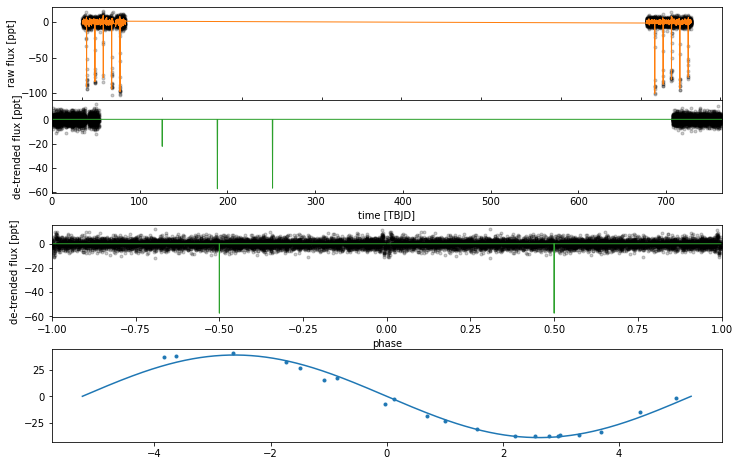

In [66]:
model, map_soln, extras, start, opti_logp = build_model(mask, map_soln)
print(len(mask), len(extras['x']))
plot_diagnostic_plots(map_soln, extras, mask=None)
# plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_lightcurves_w_model_after_outlier_removal_w_s1_params.png", dpi=150, bbox_inches='tight')

In [29]:
with model:
    trace = pm.sample(
        tune=500,
        draws=1000,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=4,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136681, 261136682,261136683,261136684],
        init='adapt_full'
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, t0, log_period, b, log_s, log_q, logK, log_k, log_R1, log_M1, u2, u1, mean_rv, mean_lc]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3395 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9036483199309083, but should be close to 0.95. Try to increase the number of tuning steps.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


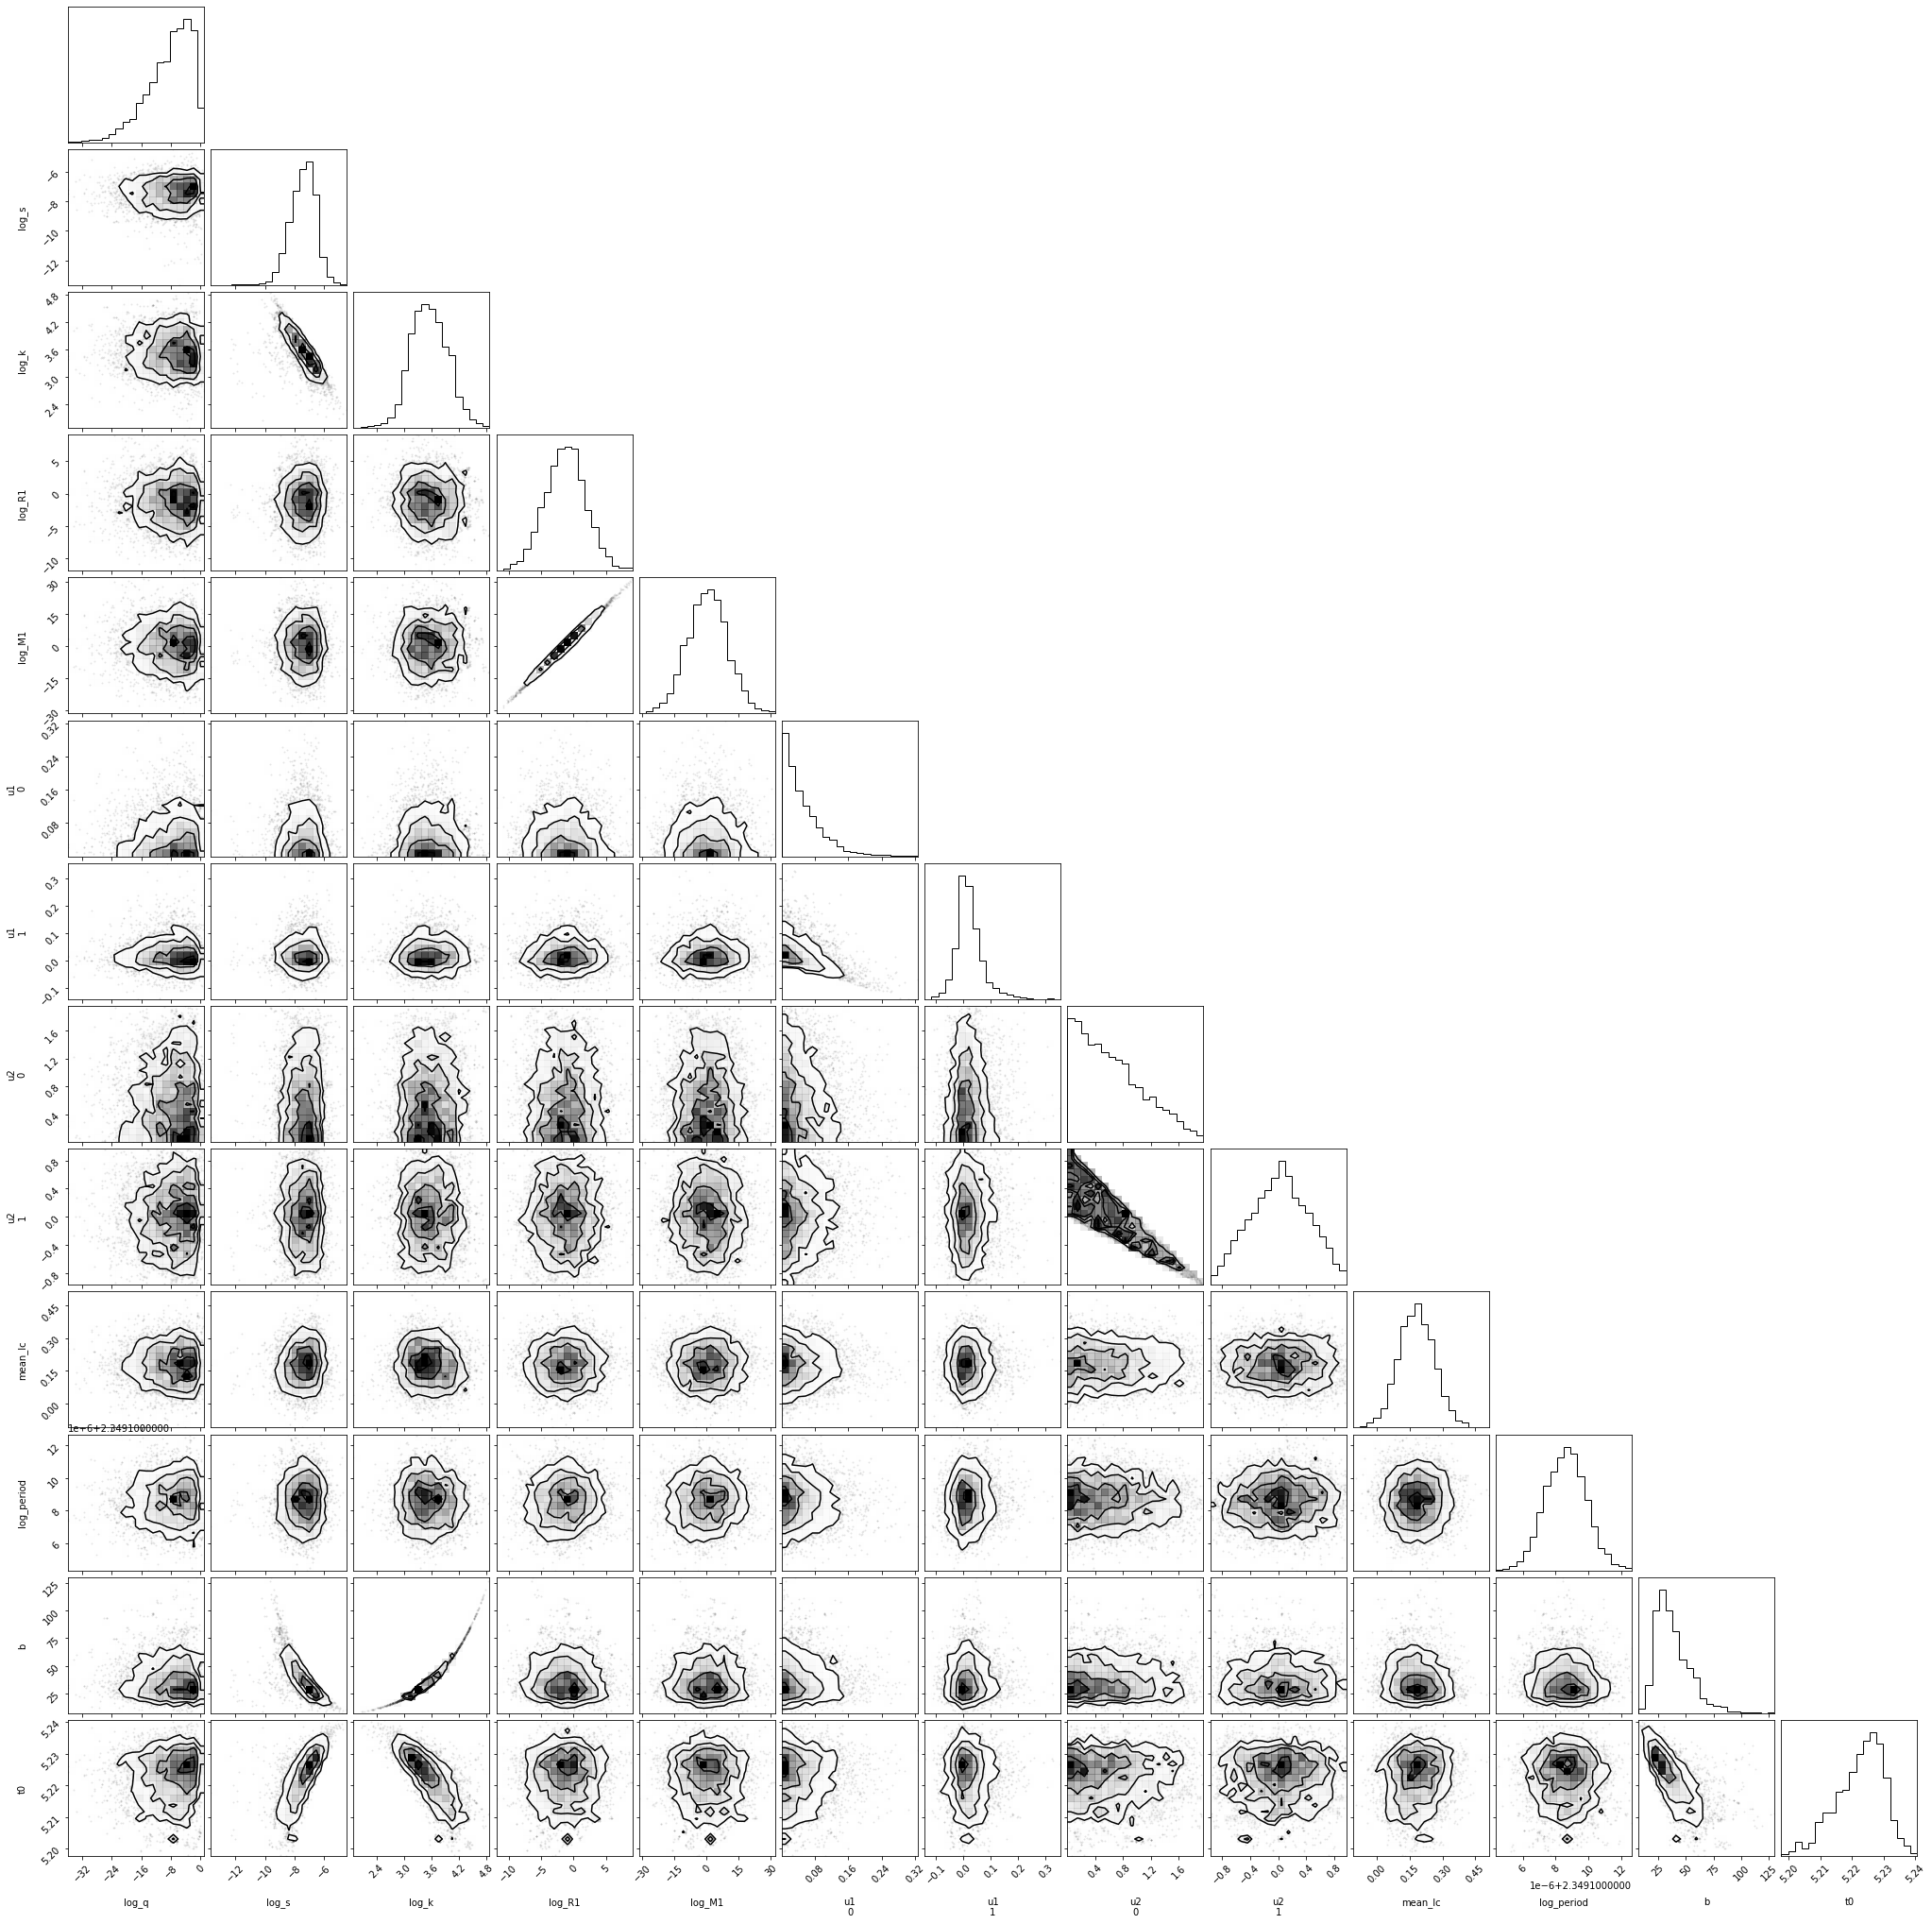

In [33]:
_ = corner(trace, var_names=['log_q','log_s','log_k','log_R1','log_M1','u1','u2','mean_lc','log_period','b','t0'])

In [31]:
az.summary(trace, var_names=['log_q','log_s','log_k','log_R1','log_M1','u1','u2','mean_lc','log_period','b','t0'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_q,-8.486,6.002,-19.781,0.373,0.230,0.163,467.0,58.0,1.02
log_s,-7.453,0.887,-9.109,-5.982,0.047,0.036,435.0,281.0,1.01
log_k,3.546,0.402,2.830,4.316,0.017,0.012,556.0,530.0,1.01
log_R1,-1.259,3.142,-7.378,4.412,0.130,0.092,590.0,1294.0,1.01
log_M1,0.306,9.427,-17.560,17.735,0.392,0.277,582.0,1048.0,1.01
u1[0],0.051,0.047,0.000,0.135,0.001,0.001,2330.0,1823.0,1.00
u1[1],0.020,0.050,-0.066,0.125,0.001,0.001,2506.0,2868.0,1.00
u2[0],0.643,0.462,0.001,1.493,0.009,0.007,2508.0,2060.0,1.00
u2[1],0.018,0.411,-0.737,0.764,0.008,0.007,2902.0,2468.0,1.00
mean_lc,0.179,0.082,0.030,0.337,0.002,0.001,2667.0,2548.0,1.00


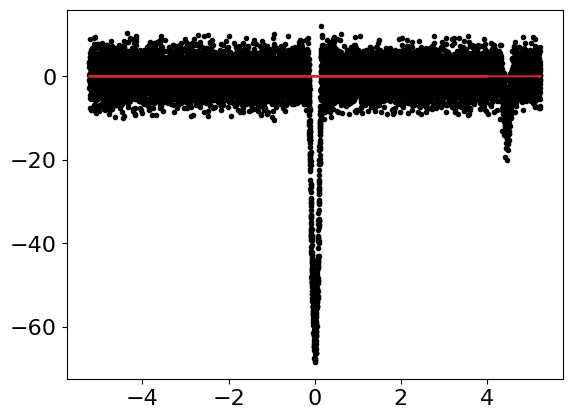

In [42]:
xo.utils.docs_setup()
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
with model:
    gp_pred = (
        pmx.eval_in_model(extras["gp_lc_pred"], map_soln) + map_soln["mean_lc"]
    )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])
ecc = np.median(flat_samps['ecc'])
omega = np.median(flat_samps['omega'])
b = np.median(flat_samps['b'])
R1 = np.median(flat_samps['R1'])
R2 = np.median(flat_samps['R2'])
M1 = np.median(flat_samps['M1'])
M2 = np.median(flat_samps['M2'])
u1 = np.median(flat_samps['u1'],axis=-1)
u2 = np.median(flat_samps['u2'],axis=-1)
s = np.median(flat_samps['s'])
mean_lc = np.median(flat_samps['mean_lc'])

vars_of_interest = ["period", "t0",
                    "ecc", "omega","b",
                    "R1","M1","R2","M2",
                    "u1","u2",'s']

orbit = xo.orbits.KeplerianOrbit(
    period=p,
    t0=t0,
    ecc=ecc,
    omega=omega,
    b=b,
    r_star=R2,
    m_star=M2,
    m_planet=M1,
)


light_curve = (
    xo.SecondaryEclipseLightCurve(u1, u2, s)
    .get_light_curve(orbit=orbit, r=R1, t=x[mask], texp=texp)
).eval()

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_pred, ".k", label="data", zorder=-1000)
plt.plot(x_fold, light_curve, c='C3')

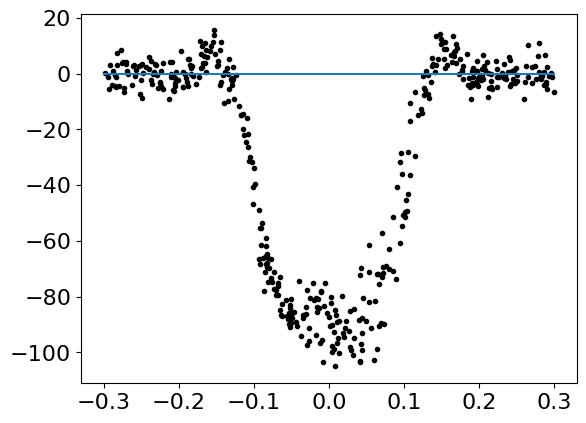

In [303]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))
# for data_var in flat_samps.data_vars.keys():
#     print(data_var)
plt.figure()



# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
m = np.abs(x_fold) < 0.3
plt.plot(
    x_fold[m], y[mask][m], ".k", label="data", zorder=-1000
)


lcpred = np.percentile(flat_samps['lc_pred'], 50,axis=0)
mod_phase = np.linspace(-.3, 0.3, len(lcpred))
plt.plot(mod_phase, lcpred)